In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.special import spherical_jn
from tqdm import tqdm

from interaction import LocalSystem, potential
import constants as const
import utility
import bind

plt.style.use('science')
gr = 4/3
h = 3

In [2]:
HBAR = 1.054572e-34
A0 = 5.291772e-11
ME = 9.109384e-31

In [3]:
const.BETA4

32.70989286766126

In [4]:
def alpha(r):
    return 9/2 - 2/3*np.exp(-2*r) * (r**5 + 9/2*r**4 + 9*r**3 + 27/2*r**2 + 27/2*r + 27/4)
def mm_potential(r):
    return -1/2 * alpha(r) / r**4

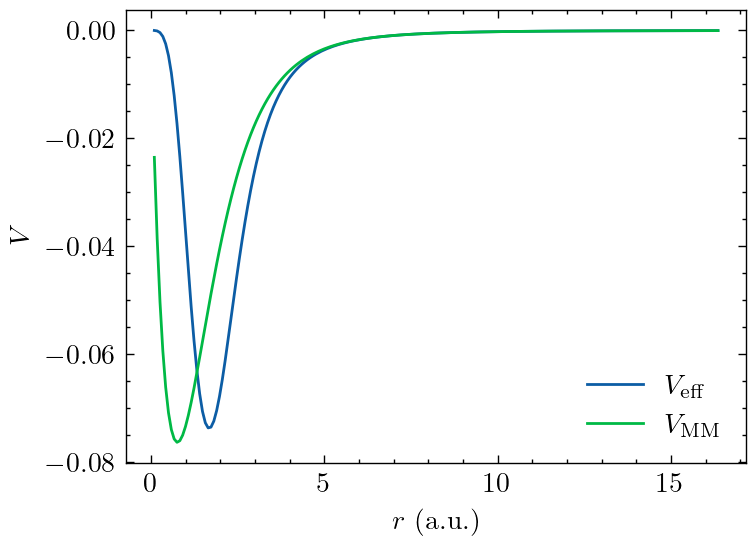

In [5]:
rs = np.linspace(0.1, 0.5*const.BETA4, 200)

fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

# ax.plot(rs, potential(rs, 1.3) / mm_potential(rs))
ax.plot(rs, potential(rs, 1.5), label=r'$V_{\rm eff}$')
ax.plot(rs, mm_potential(rs), label=r'$V_{\rm MM}$')

ax.legend()
ax.set_xlabel(r'$r$ (a.u.)')
ax.set_ylabel(r'$V$')

plt.savefig('notes/figures/V_comparison.pdf');

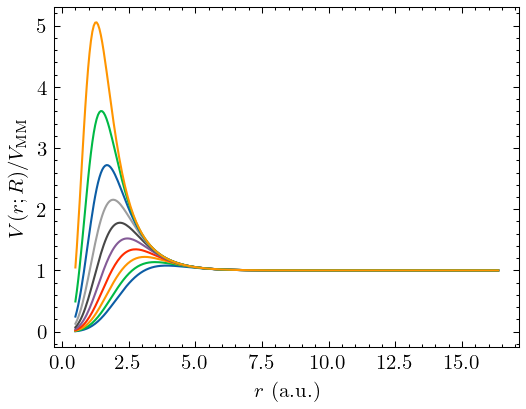

In [6]:
rs = np.linspace(0.5, 0.5*const.BETA4, 300)

fig, ax = plt.subplots(figsize=(gr*h, h), dpi=150)
fig.patch.set_facecolor('white')

for R in np.linspace(const.BETA4/16, const.BETA4/32, 10):
    ax.plot(rs, potential(rs, R) / mm_potential(rs))

ax.set_xlabel(r'$r$ (a.u.)')
ax.set_ylabel(r'$V(r;R)/V_{\rm MM}$')

plt.savefig('notes/figures/V_rel_comparison.pdf');

In [7]:
ls = LocalSystem(1.5)

In [8]:
mm_vtilde = utility.ft_matrix_gen(mm_potential, 0, 0, ls.q, ls.r_nodes, ls.r_weights)

In [9]:
mm_evals, mm_evecs = bind.bound_states(mm_vtilde, 0, 0, ls.q, ls.wq)

In [10]:
def ftr(state, r, q, wq):
    return np.array([np.sum(np.sqrt(2/np.pi) * wq * q**2 * state * spherical_jn(0, q*ri)) for ri in r])

In [11]:
def f(g, ls):
    return mm_evals[-1] - ls.bound_state_spectrum(g, 0)[0]

In [12]:
result = optimize.fsolve(f, -0.0002, args=(ls), factor=0.1)[0]

In [13]:
evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(result, 0), 1, ls.q, ls.wq)

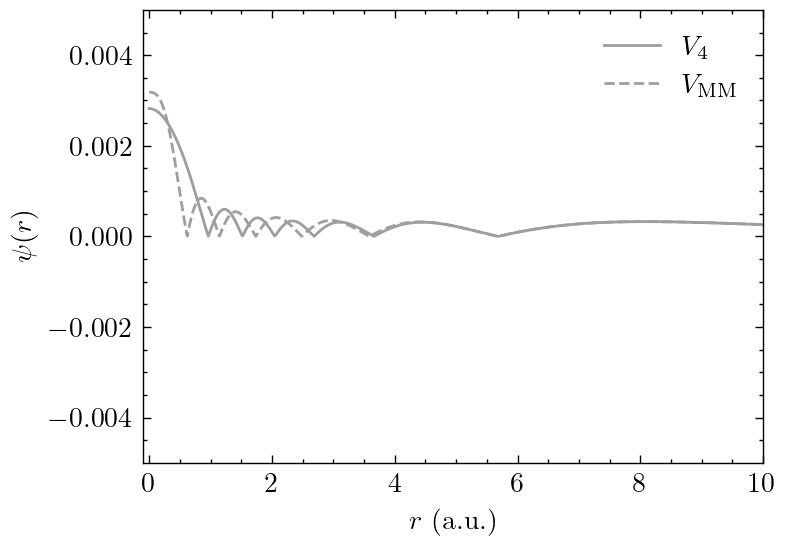

In [14]:
fig, ax = plt.subplots(figsize=((gr*h, h)), dpi=200)
fig.patch.set_facecolor('white')

for i in range(6, 7):
    ax.plot(ls.r_nodes, np.abs(ftr(evecs[:, i], ls.r_nodes, ls.q, ls.wq)), color=f'C{i}', label=r'$V_4$')
    ax.plot(ls.r_nodes, np.abs(ftr(mm_evecs[:, i], ls.r_nodes, ls.q, ls.wq)), linestyle='--', color=f'C{i}',
            label=r'$V_{\rm MM}$')

# ax.plot(r[10:], mm_potential(r[10:]), color='C6', linestyle='--', label=r'$V_{\rm MM}$')
ax.set_xlim([-0.1, 10])
# ax.set_xlim([4, 20])
ax.set_ylim([-0.005, 0.005])
ax.legend()
ax.set_xlabel(r'$r$ (a.u.)')
ax.set_ylabel(r'$\psi(r)$');

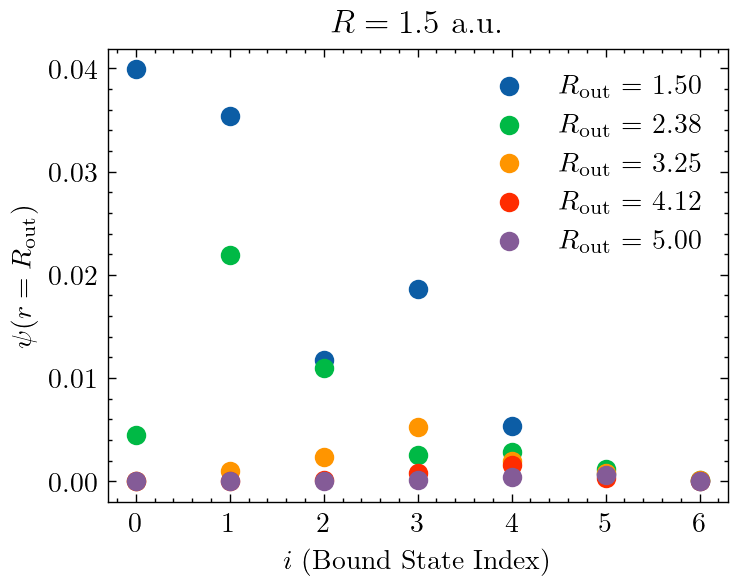

In [15]:
fig, ax = plt.subplots(figsize=((gr*h, h)), dpi=200)
fig.patch.set_facecolor('white')

Rs = np.linspace(1.5, 5, 5)

for (j, R) in enumerate(Rs):
    for i in range(7):
        psi = np.abs(ftr(evecs[:, i], ls.r_nodes, ls.q, ls.wq)) / ls.r_nodes
        ii = np.argmin(np.abs(ls.r_nodes - R))
        ax.scatter(i, psi[ii], color=f'C{j}', marker='o', label=r'$R_{\rm out}$ = %.2f' % R if i == 0 else None)

ax.legend()
ax.set_xlabel(r'$i$ (Bound State Index)')
ax.set_ylabel(r'$\psi(r=R_{\rm out})$')
ax.set_title(r'$R=1.5$ a.u.');

In [16]:
ii = np.argmin(np.abs(ls.r_nodes - 5))
psi0sq = np.zeros(7)

for i in range(7):
    psi = np.abs(ftr(evecs[:, i], ls.r_nodes, ls.q, ls.wq)) / ls.r_nodes
    psi0sq[i] = psi[ii]**2

In [17]:
mm_evals

array([-0.06476107, -0.04422803, -0.02740797, -0.0146628 , -0.00611707,
       -0.00156364, -0.00012028])

In [18]:
evals

array([-0.06599509, -0.04486245, -0.0279608 , -0.01521142, -0.00638178,
       -0.00158915, -0.00012028])

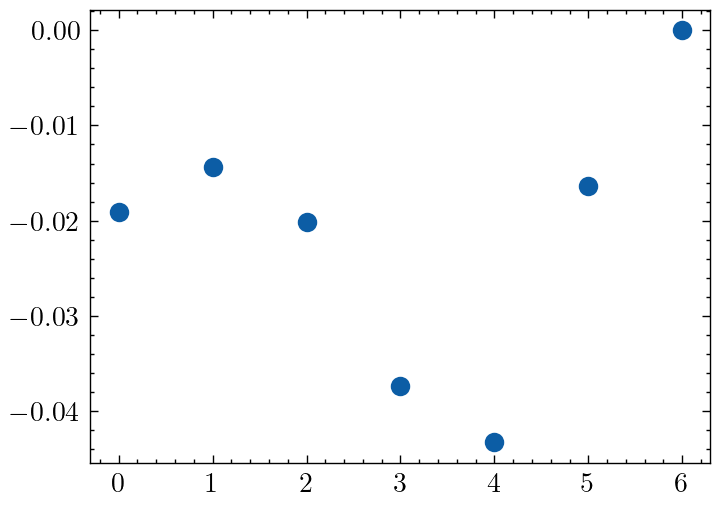

In [19]:
fig, ax = plt.subplots(figsize=((gr*h, h)), dpi=200)
fig.patch.set_facecolor('white')

ax.scatter(range(7), (mm_evals - evals)/mm_evals);

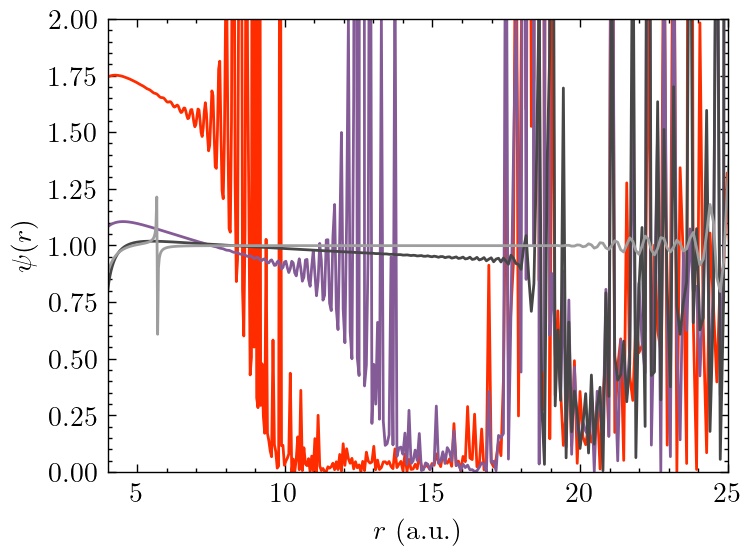

In [20]:
fig, ax = plt.subplots(figsize=((gr*h, h)), dpi=200)
fig.patch.set_facecolor('white')

for i in range(3, 7):
    x = np.abs(ftr(evecs[:, i], ls.r_nodes, ls.q, ls.wq))
    xp = np.abs(ftr(mm_evecs[:, i], ls.r_nodes, ls.q, ls.wq))
    ax.plot(ls.r_nodes, x/xp, color=f'C{i}')

# ax.plot(r[10:], mm_potential(r[10:]), color='C6', linestyle='--', label=r'$V_{\rm MM}$')
# ax.set_xlim([-0.1, 6])
ax.set_xlim([4, 25])
ax.set_ylim([0, 2])
# ax.set_ylim([-0.001, 0.001])
# ax.legend()
ax.set_xlabel(r'$r$ (a.u.)')
ax.set_ylabel(r'$\psi(r)$');

In [21]:
def probability(psi, r_max):
    ii = np.where(ls.r_nodes < r_max)[0]
    return np.sum(ls.r_weights[ii] * ls.r_nodes[ii]**2 * np.abs(psi[ii])**2)

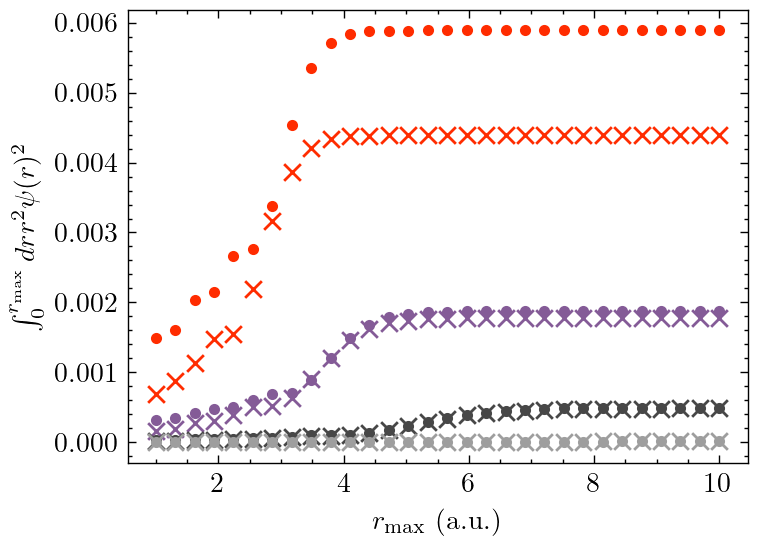

In [22]:
fig, ax = plt.subplots(figsize=((gr*h, h)), dpi=200)
fig.patch.set_facecolor('white')

for i in range(3, 7):
    x = ftr(evecs[:, i], ls.r_nodes, ls.q, ls.wq)
    xp = ftr(mm_evecs[:, i], ls.r_nodes, ls.q, ls.wq)
    for rmax in np.linspace(1, 10, 30):
        ax.scatter(rmax, probability(x, rmax), color=f'C{i}', marker='.')
        ax.scatter(rmax, probability(xp, rmax), color=f'C{i}', marker='x')

# ax.plot(r[10:], mm_potential(r[10:]), color='C6', linestyle='--', label=r'$V_{\rm MM}$')
# ax.set_xlim([-0.1, 6])
# ax.set_xlim([4, 25])
# ax.set_ylim([0, 2])
# ax.set_ylim([-0.001, 0.001])
# ax.legend()
ax.set_xlabel(r'$r_{\rm max}$ (a.u.)')
ax.set_ylabel(r'$\int_0^{r_{\rm max}} dr r^2 \psi(r)^2$');

In [23]:
evals

array([-0.06599509, -0.04486245, -0.0279608 , -0.01521142, -0.00638178,
       -0.00158915, -0.00012028])

In [25]:
from scipy.special import spherical_jn

TypeError: ftr() missing 3 required positional arguments: 'r', 'q', and 'wq'

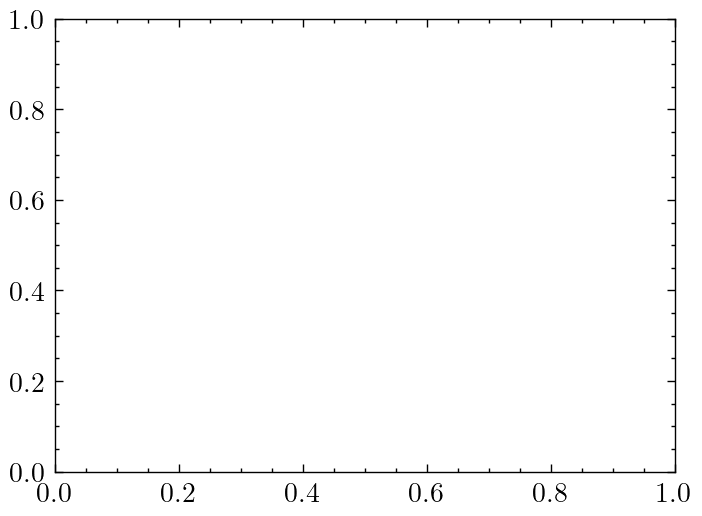

In [27]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for state in evecs.T:
    ax.plot(ls.r_nodes, ftr(state))
    
ax.plot(r[10:], mm_potential(r[10:]), color='C6', linestyle='--', label=r'$V_{\rm MM}$')
ax.set_xlim([-1, 10])
ax.legend()
ax.set_xlabel(r'$r$ (a.u.)')
ax.set_ylabel(r'$\psi(r)$');

In [ ]:
np.array([np.sqrt(2/np.pi) * wq @ q**2 * ])

In [ ]:
LC_RESULTS = bind.spectrum(vtilde, 0, 0, q, wq)

In [ ]:
b = (const.MU * 9/2)**0.25

In [ ]:
amu = 1.66e-27 # kg
mass = 1.00784 * amu / 1.783e-36 / 1e6

In [ ]:
mass / const.MASS_ELECTRON

In [ ]:
NUM_SWAVE_STATES = 7
Rs = np.linspace(1.5, 0.375, 10)

In [ ]:
partial_waves = list(range(7))

In [ ]:
class Spectra:
    def __init__(self, R, g):
        self.R = R
        self.g = g
        self.spectra = []
        for l in partial_waves:
            ls = LocalSystem(self.R, ell=l)
            spectrum = ls.bound_state_spectrum(self.g, 0)
            self.spectra.append(spectrum)

In [ ]:
from scipy.interpolate import interp1d

In [ ]:
def interp_from_last_five(x, y, x_new, y_old):
    if len(y) >= 5:
        ii = np.where(x < x_new)[0]
        xp = x[ii]
        f = interp1d(xp[-5:], y[-5:], kind='cubic', fill_value='extrapolate')
        return f(x_new)
    else:
        return y_old

In [ ]:
ls = LocalSystem(2)

In [ ]:
LC_RESULTS[0]

In [ ]:
guess = -0.0575
ls.bound_state_spectrum(guess, 0)

In [ ]:
Rs = 1/np.linspace(1/2, 1/1, 50)

In [56]:
spectra = []
gs = np.array([])

for (i, R) in enumerate(Rs):
    ls = LocalSystem(R)
    result = optimize.fsolve(f, guess, args=(ls), factor=0.01)
    g = result[0]
    spectrum = ls.bound_state_spectrum(g, 0)
    n = spectrum.size
    print(f'R = {R:.2f}  g = {g:.2e}  guess = {guess:.2e}  N = {n}  GS = {spectrum[-1]:.4f}')
    spectra.append(spectrum)
    gs = np.append(gs, g)
    R -= 0.1
    g
    if i >= 5:
        func = interp1d(Rs[:i], gs[:i], kind='cubic', fill_value='extrapolate')
        guess = func(R)
    else:
        guess = g

R = 2.00  g = -5.75e-02  guess = -5.75e-02  N = 7  GS = -0.0540
R = 1.96  g = -5.61e-02  guess = -5.75e-02  N = 7  GS = -0.0533
R = 1.92  g = -5.46e-02  guess = -5.61e-02  N = 7  GS = -0.0527
R = 1.88  g = -5.29e-02  guess = -5.46e-02  N = 7  GS = -0.0521
R = 1.85  g = -5.10e-02  guess = -5.29e-02  N = 7  GS = -0.0516
R = 1.81  g = -4.89e-02  guess = -5.10e-02  N = 7  GS = -0.0512
R = 1.78  g = -4.67e-02  guess = -4.13e-02  N = 7  GS = -0.0510
R = 1.75  g = -4.43e-02  guess = -3.82e-02  N = 7  GS = -0.0510
R = 1.72  g = -4.17e-02  guess = -3.50e-02  N = 7  GS = -0.0513
R = 1.69  g = -3.90e-02  guess = -3.16e-02  N = 7  GS = -0.0519
R = 1.66  g = -3.62e-02  guess = -2.81e-02  N = 7  GS = -0.0528
R = 1.63  g = -3.33e-02  guess = -2.45e-02  N = 7  GS = -0.0541
R = 1.61  g = -3.02e-02  guess = -2.10e-02  N = 7  GS = -0.0557
R = 1.58  g = -2.72e-02  guess = -1.75e-02  N = 7  GS = -0.0576
R = 1.56  g = -2.41e-02  guess = -1.40e-02  N = 7  GS = -0.0598
R = 1.53  g = -2.09e-02  guess = -1.05e-

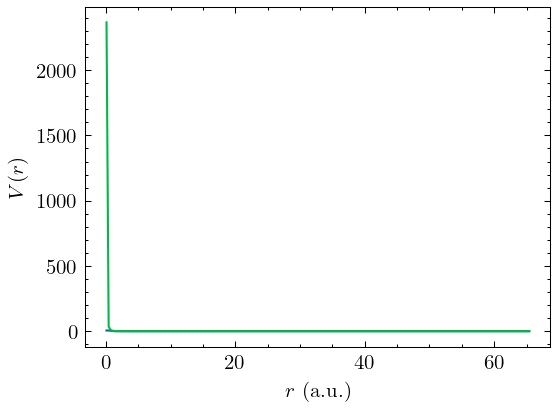

In [109]:
rs = np.linspace(0.1, 2*const.BETA4, 200)

fig, ax = plt.subplots(figsize=(gr*h, h), dpi=150)
fig.patch.set_facecolor('white')

ax.plot(rs, potential(rs, Rs[-1]) + gs[-1]*np.exp(-(rs/Rs[-1])**4))
ax.plot(rs, mm_potential(rs))

ax.set_xlabel(r'$r$ (a.u.)')
ax.set_ylabel(r'$V(r)$');

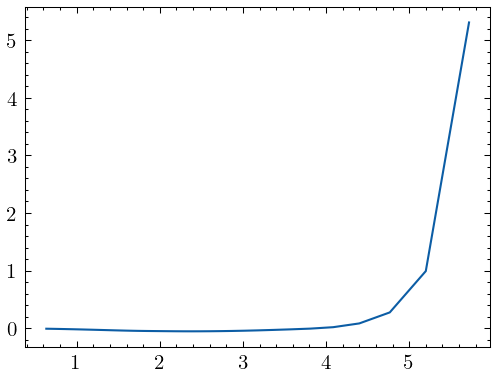

In [110]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=150)
fig.patch.set_facecolor('white')

ax.plot(b/Rs, gs);

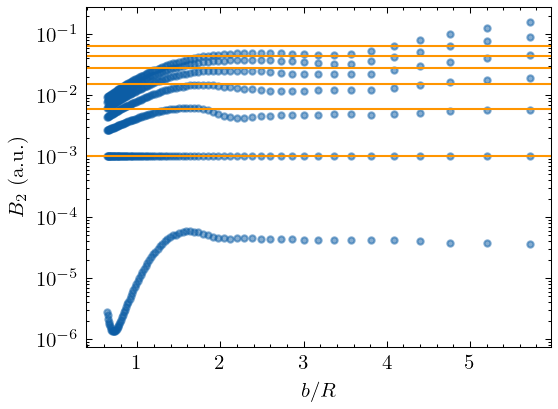

In [111]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=150)
fig.patch.set_facecolor('white')

for (R, s) in zip(Rs, spectra):
    for state in s:
            ax.scatter(b/R, np.abs(state), marker='.', color='C0', alpha=0.5)
ax.axhline(0.065, color='C2')
ax.axhline(0.044, color='C2')
ax.axhline(0.028, color='C2')
ax.axhline(0.015, color='C2')
ax.axhline(0.006, color='C2')
ax.axhline(0.001, color='C2')
ax.set_yscale('log')
ax.set_ylabel(r'$B_2$ (a.u.)')
ax.set_xlabel(r'$b/R$');

In [ ]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=150)
fig.patch.set_facecolor('white')

for s in spectra:
    pw = s.spectra[1]
    for state in pw:
            ax.scatter(const.BETA4/s.R, np.abs(state), color='C0', marker='.', alpha=0.5)
ax.set_yscale('log')

In [ ]:
ls = LocalSystem(1.44)

In [ ]:
ls.bound_state_spectrum(0.033, 0)

In [ ]:
bind.spectrum(vtilde, xtilde, 0, q, wq)

In [ ]:
Rs = np.linspace(const.BETA4/16, const.BETA4/32, 20)

In [ ]:
BETA4/1.5063766452212421

In [ ]:
R = 1.5
ls = LocalSystem(R)

In [ ]:
result = optimize.fsolve(f, -0.01, factor=0.01)

In [ ]:
result

In [ ]:
ls.bound_state_spectrum(result[0], 0)

In [ ]:
r, wr = utility.log_mesh(0, 10*BETA4, 2000)
q, wq = utility.log_mesh(0, 10*2/R, 200)

In [ ]:
ell = 6
vtilde = utility.ft_matrix_gen(lambda r: potential(r, R), ell, ell, q, r, wr)
xtilde = utility.ft_matrix_gen(lambda r: xterm(r, R, 1), ell, ell, q, r, wr)

In [ ]:
bind.spectrum(vtilde, xtilde, result[0], q, wq)